# An Exploration of Topic Modeling
## Fábio Brolesi (R.A. 023718) and Gilmar J. A. de Souza Jr. (R.A. 981250)

## Topic Modeling Study using 20 Newsgroups dataset

Using some topic modeling methods, basically BOW, LSA and LDA, we will explore the corpus from [20 Newsgropus](http://qwone.com/~jason/20Newsgroups/).


### Bag of words


[//]: # (Ele pediu para avaliar as três técnicas: Bag of words, LSA e LDA)
The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. 

The bag-of-words model is commonly used in methods of document classification, where the frequency of occurrence of each word is used as a feature for training a classifier.

In [1]:
# BASED ON http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
from sklearn.datasets import fetch_20newsgroups

In [2]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [3]:
print len(twenty_train.data)
print len(twenty_train.filenames)
print("\n".join(twenty_train.data[0].split("\n")[:3]))
print(twenty_train.target_names[twenty_train.target[0]])
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

2257
2257
From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
comp.graphics
comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
print X_train_counts.shape
count_vect.vocabulary_.get(u'algorithm')

(2257, 35788)


4690

In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
print X_train_tf.shape
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print X_train_tfidf.shape

(2257, 35788)
(2257, 35788)


In [6]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [7]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


In [8]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

In [9]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test',
    categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)  

0.83488681757656458

In [10]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])
_ = text_clf.fit(twenty_train.data, twenty_train.target)
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target) 

0.9127829560585885

In [11]:
from sklearn import metrics
print(metrics.classification_report(twenty_test.target, predicted,
    target_names=twenty_test.target_names))
metrics.confusion_matrix(twenty_test.target, predicted)

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.81      0.87       319
         comp.graphics       0.88      0.97      0.92       389
               sci.med       0.94      0.90      0.92       396
soc.religion.christian       0.90      0.95      0.93       398

           avg / total       0.92      0.91      0.91      1502



array([[258,  11,  15,  35],
       [  4, 379,   3,   3],
       [  5,  33, 355,   3],
       [  5,  10,   4, 379]])

In [12]:
from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(twenty_train.data[:400], twenty_train.target[:400])
twenty_train.target_names[gs_clf.predict(['God is love'])]
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print score                                              

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)
0.9


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


### Latent Semantic Analysis
[//]: # (https://technowiki.wordpress.com/2011/08/27/latent-semantic-analysis-lsa-tutorial/)
[//]: # (http://www1.se.cuhk.edu.hk/~seem5680/lecture/LSI-Eg.pdf)
[//]: # (http://journalofdigitalhumanities.org/2-1/topic-modeling-a-basic-introduction-by-megan-r-brett/)
Latent Semantic Analysis, also known as Latent Semantic Indexing is a way to perform Topic Modeling. It aims to analyzing documents to find the underlying meaning or concepts of those documents. If each word only meant one concept, and each concept was only described by one word, then LSA would be easy since there is a simple mapping from words to concepts.

LSI has been used in several ways. The most obvious and common way is to analyze the similarity between bodies of text. This can be used in dozens of interesting ways, from finding related documents in a group to doing paragraph-wise LSI to find site summaries. It can also be used to facilitate a "smart" search of your document space, and even do document categorization (read: SPAM filtering!)
The most common operation is to take the inner product (dot product) of two of the LSI vectors and perform operations with that information. Sometimes, it may make sense to do this operation on your unit LSI vectors, particularly when you are searching on a vector that is a search term, it will almost never have the magnitude that a full document would have.

#### How Latent Semantic Analysis Works

Latent Semantic Analysis arose from the problem of how to find relevant documents from search words. The fundamental difficulty arises when we compare words to find relevant documents, because what we really want to do is compare the meanings or concepts behind the words. LSA attempts to solve this problem by mapping both words and documents into a “concept” space and doing the comparison in this space.

Since authors have a wide choice of words available when they write, the concepts can be obscured due to different word choices from different authors. This essentially random choice of words introduces noise into the word-concept relationship. Latent Semantic Analysis filters out some of this noise and also attempts to find the smallest set of concepts that spans all the documents.

In order to make this difficult problem solvable, LSA introduces some dramatic simplifications.

Documents are represented as “bags of words”, where the order of the words in a document is not important, only how many times each word appears in a document.
Concepts are represented as patterns of words that usually appear together in documents. For example “leash”, “treat”, and “obey” might usually appear in documents about dog training.
Words are assumed to have only one meaning. This is clearly not the case (banks could be river banks or financial banks) but it makes the problem tractable.

### LSA (LSI) using Gensim

In [13]:
# BASED ON https://radimrehurek.com/gensim/dist_lsi.html
# more in http://www.puffinwarellc.com/index.php/news-and-articles/articles/33.html?showall=1
from gensim import corpora, models, utils
from sklearn.datasets import fetch_20newsgroups
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [14]:
corpus = corpora.MmCorpus('deerwester.mm')
id2word = corpora.Dictionary.load('deerwester.dict')
lsi = models.LsiModel(corpus, id2word=id2word, num_topics=200, chunksize=1, distributed=False)
lsi.print_topics(num_topics=2, num_words=5)

['0.644*"system" + 0.404*"user" + 0.301*"eps" + 0.265*"time" + 0.265*"response"',
 '0.623*"graph" + 0.490*"trees" + 0.451*"minors" + 0.274*"survey" + -0.167*"system"']

### LDA


### Latent Dirichlet Allocation
[//]: # (http://www.mblondel.org/journal/2010/08/21/latent-dirichlet-allocation-in-python/)
[//]: # (http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)
[//]: # (http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf)
[//]: # (https://www.quora.com/What-is-a-good-explanation-of-Latent-Dirichlet-Allocation)

Latent Dirichlet Allocation (LDA) is an algorithm which, given a collection of documents and nothing more (no supervision needed), can uncover the "topics" expressed by documents in that collection. LDA can be seen as a Bayesian extension of pLSA.

As Blei[1] points out, the topic proportions in pLSA are tied with the training documents. This is problematic: 1) the number of parameters grows linearly with the number of training documents, which can cause serious overfitting 2) it is difficult to generalize to new documents and requires so-called “folding-in”. LDA fixes those issues by being a fully generative model: where pLSA uses a matrix of *P(topic|document)* probabilities, LDA uses a distribution over topics.
LDA is a statistical model of document collections that tries to capture this intuition. It is most easily described by its generative process, the imaginary random process by which the model assumes the documents arose. (The interpretation of LDA as a probabilistic model is fleshed out later.) We formally define a topic to be a distribution over a fixed vocabulary. For example, the genetics topic has words about genetics with high probability and the evolutionary biology topic has words about evolutionary biology with high probability. We assume that these topics are specified before any data has been generated.

In [15]:
# http://stackoverflow.com/questions/15016025/how-to-print-the-lda-topics-models-from-gensim-python
# https://radimrehurek.com/gensim/tut2.html
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models, similarities
from gensim.models import hdpmodel, ldamodel
dictionary = corpora.Dictionary.load('deerwester.dict')
corpus = corpora.MmCorpus('deerwester.mm')
print(corpus)

MmCorpus(9 documents, 12 features, 28 non-zero entries)


In [16]:
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
doc_bow = [(0, 1), (1, 1)]
print(tfidf[doc_bow]) # step 2 -- use the model to transform vectors

[(0, 0.7071067811865476), (1, 0.7071067811865476)]


In [17]:
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.5773502691896257), (1, 0.5773502691896257), (2, 0.5773502691896257)]
[(0, 0.44424552527467476), (3, 0.44424552527467476), (4, 0.44424552527467476), (5, 0.3244870206138555), (6, 0.44424552527467476), (7, 0.3244870206138555)]
[(2, 0.5710059809418182), (5, 0.4170757362022777), (7, 0.4170757362022777), (8, 0.5710059809418182)]
[(1, 0.49182558987264147), (5, 0.7184811607083769), (8, 0.49182558987264147)]
[(3, 0.6282580468670046), (6, 0.6282580468670046), (7, 0.45889394536615247)]
[(9, 1.0)]
[(9, 0.7071067811865475), (10, 0.7071067811865475)]
[(9, 0.5080429008916749), (10, 0.5080429008916749), (11, 0.695546419520037)]
[(4, 0.6282580468670046), (10, 0.45889394536615247), (11, 0.6282580468670046)]


# Dicas-L

We use the archive of tips from [dicas-l] (www.dicas-l.com.br/arquivo/), a electronic newsletter that provides daily techonnology tips (most of it related to Linux) since 1997.

## Preprocessing
First of all, we will download, extract and clean the data from dicas-l website.

In [56]:
import urllib
import zipfile
import codecs
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup
import nltk
import pandas as pd
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from gensim import corpora, models, similarities
import warnings

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')
%matplotlib inline

In [19]:
def load_lines_from_file(filename, encoding=None):
    result = []
    line_count = 0
    try:
        with codecs.open(filename, 'r', encoding) as f:   
            for line in f.readlines():
                line_count += 1
                #result.append(UTF8Writer(line.strip()))
                result.append(line.strip())
    except:
        print "Error on file",filename," - line",line_count
        raise
    return result

def write_lines_to_file(lines, filename, encoding=None):
    with codecs.open(filename, 'w', encoding) as voc_file:
        for line in lines:
            voc_file.write("%s\n" % line)
    
def load_stopwords(stopwords_folder):
    stopwords_files = [f for f in listdir(stopwords_folder) if isfile(join(stopwords_folder, f))]
    stop_words = []
    for file_name in stopwords_files:
        words = load_lines_from_file(join(stopwords_folder, file_name), 'utf-8')
        stop_words.extend(words)
    return stop_words  

In [20]:
archive_zip = 'dicas-l.zip'
folder = './dicas-l/'
url_archive_zip = 'http://dicas-l.com.br/dicas-l/' + archive_zip
download_file = False
extract_file = False
reprocess = False
processed_file = "dicas-l.csv"
cleaned_file = "dicas-l-cleaned.txt"
stopwords_folder = "./stopwords/"

In [21]:
# DOWNLOAD AND EXTRACT
if(download_file):
    file_download = urllib.URLopener()
    file_download.retrieve(url_archive_zip, archive_zip)
if(extract_file):
    with zipfile.ZipFile(archive_zip, "r") as z:
        z.extractall(folder)

In [22]:
# CLEANING AND GETTING THE DATES 
if reprocess:
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = load_stopwords(stopwords_folder)
    docs = [f for f in listdir(folder) if isfile(join(folder, f))]
    docs = sorted(docs)
    output_lines = []
    for doc in docs:
        article_dt = doc[0:8]
        if article_dt.isdigit():
            doc_lines = load_lines_from_file(folder + doc, encoding='ISO-8859-1')
            raw_text = ''
            for line in doc_lines:
                raw_text = raw_text + line.replace('\n', ' ').strip()
            original_text = BeautifulSoup(raw_text.lower()).get_text(' ')
            clean_text = ' '.join([word for word in nltk.word_tokenize(original_text) \
                                   if word not in stopwords])
            clean_text_stem = ' '.join([stemmer.stem(word) for word in nltk.word_tokenize(original_text) \
                                   if word not in stopwords])
            article_year = article_dt[0:4]
            article_month = article_dt[4:6]
            article_day = article_dt[6:8]
            output_line = article_year + ',' + article_month + ',' + article_day + ',"' + clean_text + \
                '","' + clean_text_stem + '"'
            #'","' + original_text + '","' + raw_text +'"'
            output_lines.append(output_line)
        else:
            print "skipped "+doc
    write_lines_to_file(output_lines, processed_file, encoding='utf-8')

In [23]:
text_df = pd.read_csv(processed_file, quotechar='"', quoting=2, header=None, \
                      names=['year','month','day','text', 'text_stemmed'], encoding='utf-8')

In [24]:
text_df['period'] = text_df['year'].map(str) + '/' + text_df['month'].map(str)
print len(text_df.index)
print text_df.describe()
text_df.head()

5454
              year        month          day
count  5454.000000  5454.000000  5454.000000
mean   2005.931793     6.535387    15.708838
std       5.091617     3.433865     8.862187
min    1997.000000     0.000000     1.000000
25%    2002.000000     4.000000     8.000000
50%    2006.000000     7.000000    16.000000
75%    2010.000000    10.000000    23.000000
max    2016.000000    12.000000    97.000000


,year,month,day,text,text_stemmed,period
0,1997,1,1,caso zipline colaboração : cezar taurion exemp...,cas ziplin colabor : cez taurion exempl intere...,1997/1
1,1997,3,3,receitas uso comando find - versão impressão r...,receit uso com find - vers impress receit uso ...,1997/3
2,1997,3,4,programa gzip - versão impressão programa gzip...,program gzip - vers impress program gzip colab...,1997/3
3,1997,3,5,comando dd - versão impressão comando dd colab...,com dd - vers impress com dd colabor : rub que...,1997/3
4,1997,3,6,man pages - versão impressão man pages colabor...,man pag - vers impress man pag colabor : rub q...,1997/3


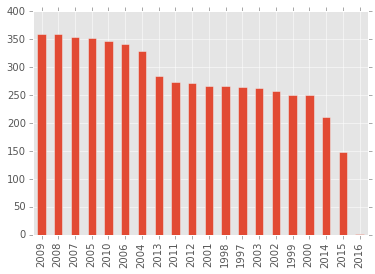

In [25]:
text_df['year'].value_counts().plot(kind='bar')

In [26]:
corpus = map(lambda txt: txt, text_df['text'])
print len(corpus)
pprint(corpus[0:2])

5454
[u'caso zipline colabora\xe7\xe3o : cezar taurion exemplo interessante , empresa software brasileira , localizada interior rio sul . zipline tecnologia nove anos exist\xeancia trabalha principalmente hospedagem sites administra\xe7\xe3o servidores empresas regi\xe3o . percebeu mercado hospedagem sites canibalizando resolveu entrar novo setor , maior valor agregado , ent\xe3o surgiu projeto egestor ( http : //www.egestor.com.br ) , erp online , baseado modelo saas arquitetura multi-inquilino . segundo executivos , egestor experi\xeancia dando certo , mercado relativamente desconhecido . maioria vendas servi\xe7o pessoas maior conhecimento tecnologia , empres\xe1rios mais tradicionais t\xeam certo receio manter informa\xe7\xf5es servidor internet . 100 % receita obtida assinaturas . software saas , zipline permite per\xedodo experi\xeancias , imposs\xedvel software ser instalado configurado casa cliente . caso egestor , decidir aquisi\xe7\xe3o servi\xe7o , clientes testaram sistema 

In [27]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"(?u)[\b\#a-zA-Z][\w&-_]+\b")

corpus_tokens = map(lambda d: [token for token in tokenizer.tokenize(d)], corpus)
pprint(corpus_tokens[0:2])

[[u'caso',
  u'zipline',
  u'colabora\xe7\xe3o',
  u'cezar',
  u'taurion',
  u'exemplo',
  u'interessante',
  u'empresa',
  u'software',
  u'brasileira',
  u'localizada',
  u'interior',
  u'rio',
  u'sul',
  u'zipline',
  u'tecnologia',
  u'nove',
  u'anos',
  u'exist\xeancia',
  u'trabalha',
  u'principalmente',
  u'hospedagem',
  u'sites',
  u'administra\xe7\xe3o',
  u'servidores',
  u'empresas',
  u'regi\xe3o',
  u'percebeu',
  u'mercado',
  u'hospedagem',
  u'sites',
  u'canibalizando',
  u'resolveu',
  u'entrar',
  u'novo',
  u'setor',
  u'maior',
  u'valor',
  u'agregado',
  u'ent\xe3o',
  u'surgiu',
  u'projeto',
  u'egestor',
  u'http',
  u'www.egestor.com.br',
  u'erp',
  u'online',
  u'baseado',
  u'modelo',
  u'saas',
  u'arquitetura',
  u'multi-inquilino',
  u'segundo',
  u'executivos',
  u'egestor',
  u'experi\xeancia',
  u'dando',
  u'certo',
  u'mercado',
  u'relativamente',
  u'desconhecido',
  u'maioria',
  u'vendas',
  u'servi\xe7o',
  u'pessoas',
  u'maior',
  u'conh

In [28]:
dictionary = corpora.Dictionary(corpus_tokens)
dictionary.filter_extremes(no_below=4, no_above=0.5, keep_n=None)
dictionary.compactify()
print(dictionary)
pprint(dictionary.token2id)

Dictionary(19904 unique tokens: [u'fawn', u'celso', u'completada', u'vivemos', u'bloqueou']...)
{u'a+x': 7455,
 u'a-z': 9479,
 u'a0': 2409,
 u'a1': 2408,
 u'a2': 2411,
 u'a2enmod': 15991,
 u'a2ensite': 19568,
 u'a3': 2410,
 u'a4': 2413,
 u'a5': 2412,
 u'a7': 2414,
 u'aa': 2360,
 u'aaa': 18005,
 u'aaaa': 5115,
 u'aac': 18009,
 u'aaplica\xe7\xe3o': 3758,
 u'aaron': 5061,
 u'ab': 2363,
 u'aba': 15275,
 u'abaixo': 9960,
 u'abaixopara': 2577,
 u'abaixos': 11061,
 u'abandonado': 14528,
 u'abandonados': 8930,
 u'abandonar': 1004,
 u'abandono': 2812,
 u'abandonou': 17157,
 u'abas': 14379,
 u'abc': 12280,
 u'abc123': 11707,
 u'abcd': 3825,
 u'abcdef': 16910,
 u'abel': 5858,
 u'aberta': 5652,
 u'abertamente': 2990,
 u'abertas': 18659,
 u'aberto': 5649,
 u'abertos': 15022,
 u'abertura': 6064,
 u'abiblioteca': 1802,
 u'ability': 19374,
 u'abiword': 17141,
 u'able': 9032,
 u'abnt': 8384,
 u'abnt2': 3738,
 u'aborda': 19696,
 u'abordada': 14813,
 u'abordadas': 13145,
 u'abordado': 2170,
 u'abordados'

## Bag-of-words

In [29]:
corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_tokens]
#pprint(corpus_bow[0:2])

In [30]:
%%time
corpora.MmCorpus.serialize('dicas-l_bow.mm', corpus_bow)
dictionary.save('dicas-l.dict')

CPU times: user 3.38 s, sys: 34.9 ms, total: 3.41 s
Wall time: 3.42 s


## TF-IDF (relevant terms)

In [31]:
tfidf = models.TfidfModel(corpus_bow, normalize=True)
corpus_tfidf = tfidf[corpus_bow]
print len(list(corpus_tfidf))
#pprint(list(corpus_tfidf)[0:10])

5454


# Topics Modeling

### Auxiliar functions

In [32]:
def print_first_docs_and_their_main_topics(corpus_topics, model, docs_to_show=20, main_topics_to_show=2, main_topic_words_to_show=20):   
    docs_tokens = corpus_tokens[0:docs_to_show]
    docs_topics = []
    for topics in corpus_topics:
        docs_topics.append(topics)
        if len(docs_topics) >= docs_to_show:
            break
            
    all_topics = model.show_topics(-1, main_topic_words_to_show, False, False)
            
    for i in range(0,len(docs_tokens)):
        print "====================================="
        print "DOCUMENT",i
        print docs_tokens[i]
        print "TOPICS"
        sorted_topics = sorted(docs_topics[i], key=lambda t: -t[1])
        for t in range(0,min(main_topics_to_show, len(sorted_topics))):
            print sorted_topics[t]
            #pprint(model.show_topic(sorted_topics[t][0], topn=main_topic_words_to_show))
            pprint(all_topics[sorted_topics[t][0]])
            
def show_word_cloud(frequencies):
    wordcloud = WordCloud(width=1400, height=500).generate_from_frequencies(frequencies)
    plt.figure(figsize = (14,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt
      
def show_topics_cloud(model, topicId, get_words_from_topic_function):
    all_topics = map(get_words_from_topic_function, model.show_topics(-1, 50, False, False))
    min_score_word = float(abs(all_topics[topicId][0][1])) / 3.
    top_positive_words = filter(lambda x: x[1] >= min_score_word, all_topics[topicId])[0:20]
    show_word_cloud(top_positive_words)
    
def topics_top_words(model, max_words, get_words_from_topic_function):
    topics_top_words = []
    all_topics = map(get_words_from_topic_function, model.show_topics(-1, max_words*2, False, False))
    for topic in all_topics:    
        min_score_word = float(abs(topic[0][1])) / 3.
        top_positive_words = map(lambda y: y[0], filter(lambda x: x[1] > min_score_word, topic))[0:max_words]
        topics_top_words.append(top_positive_words)
    return topics_top_words
        
def show_topics_distrib(corpus, bins):
    #docs_main_topic = map(lambda (d, ts): (d, sorted(ts, key=lambda t: -t[1])[0][0]) if len(ts) > 0 else (d, -1), enumerate(list(corpus)))
    topics_distrib = map(lambda ts: len([t for t in ts if len(t) > 0]), corpus)
    df_docs_main_topic = pd.DataFrame(topics_distrib)
    df_docs_main_topic.hist(bins=bins, figsize=(20,10))

def show_topics_popularity(corpus, bins):
    #docs_main_topic = map(lambda (d, ts): (d, sorted(ts, key=lambda t: -t[1])[0][0]) if len(ts) > 0 else (d, -1), enumerate(list(corpus)))
    topics_popularity = map(lambda ts: sorted(ts, key=lambda t: -t[1])[0][0] if len(ts) > 0 else -10, corpus)
    df_docs_main_topic = pd.DataFrame(topics_popularity)
    print df_docs_main_topic.head()
    df_docs_main_topic.hist(bins=bins, figsize=(20,10))

## Latent Semantic Indexing

In [33]:
%%time
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=150)
corpus_lsi = lsi[corpus_tfidf]
#lsi.print_topics(150)

CPU times: user 6.33 s, sys: 267 ms, total: 6.6 s
Wall time: 6.59 s


In [34]:
lsi_topics_words_conversion = lambda x: map(lambda y: (y[1], y[0]), x)
lsi_top_words = topics_top_words(lsi,7,lsi_topics_words_conversion)
pprint(lsi_top_words)

[[u'voc\xea',
  u'linux',
  u'arquivo',
  u'software',
  u'comando',
  u'arquivos',
  u'sistema'],
 [u'software', u'livre', u'livro', u'portal', u'projeto', u'desenvolvimento'],
 [u'arquivos', u'find', u'pdf', u'comando', u'livro', u'sed', u'google'],
 [u'software'],
 [u'ssh', u'ip', u'google', u'servidor', u'web', u'lista', u'mensagens'],
 [u'firefox', u'google', u'linux', u'site', u'pacotes'],
 [u'livro', u'pdf', u'cesar', u'php', u'mysql', u'rau-tu', u'linux'],
 [u'backup',
  u'disco',
  u'linux',
  u'windows',
  u'boot',
  u'parti\xe7\xe3o',
  u'parti\xe7\xf5es'],
 [u'root', u'vim', u'natal', u'vi', u'sudo'],
 [u'ssh', u'natal', u'ee', u'pdf', u'v\xeddeo', u'imagens', u'ip'],
 [u'livro'],
 [u'google', u'v\xeddeo', u'find', u'linux', u'livro', u'kernel', u'ip'],
 [u'v\xeddeo', u'php', u'imagem', u'v\xeddeos', u'backup', u'script'],
 [u'mensagens', u'pacotes', u'lista'],
 [u'vim', u'ssh', u'backup', u'livro', u'libreoffice', u'linux', u'php'],
 [u'livro', u'backup', u'ssh', u'firefox

In [35]:
print_first_docs_and_their_main_topics(corpus_lsi, lsi)

DOCUMENT 0
[u'caso', u'zipline', u'colabora\xe7\xe3o', u'cezar', u'taurion', u'exemplo', u'interessante', u'empresa', u'software', u'brasileira', u'localizada', u'interior', u'rio', u'sul', u'zipline', u'tecnologia', u'nove', u'anos', u'exist\xeancia', u'trabalha', u'principalmente', u'hospedagem', u'sites', u'administra\xe7\xe3o', u'servidores', u'empresas', u'regi\xe3o', u'percebeu', u'mercado', u'hospedagem', u'sites', u'canibalizando', u'resolveu', u'entrar', u'novo', u'setor', u'maior', u'valor', u'agregado', u'ent\xe3o', u'surgiu', u'projeto', u'egestor', u'http', u'www.egestor.com.br', u'erp', u'online', u'baseado', u'modelo', u'saas', u'arquitetura', u'multi-inquilino', u'segundo', u'executivos', u'egestor', u'experi\xeancia', u'dando', u'certo', u'mercado', u'relativamente', u'desconhecido', u'maioria', u'vendas', u'servi\xe7o', u'pessoas', u'maior', u'conhecimento', u'tecnologia', u'empres\xe1rios', u'mais', u'tradicionais', u't\xeam', u'certo', u'receio', u'manter', u'inform

In [58]:
#Number of topics x Number of documents
#show_topics_distrib(corpus_lsi,200)
#Topics popularity
#show_topics_popularity(corpus_lsi,50)

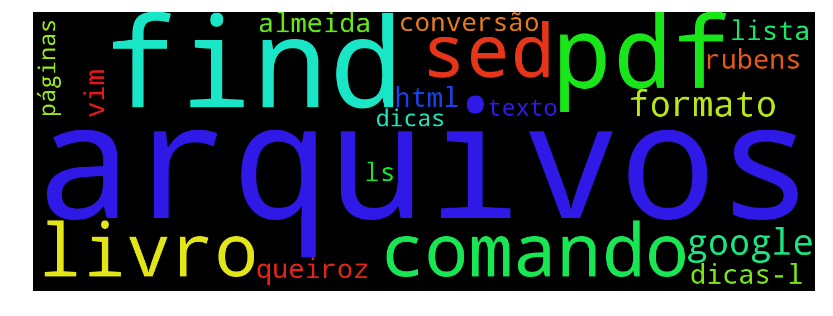

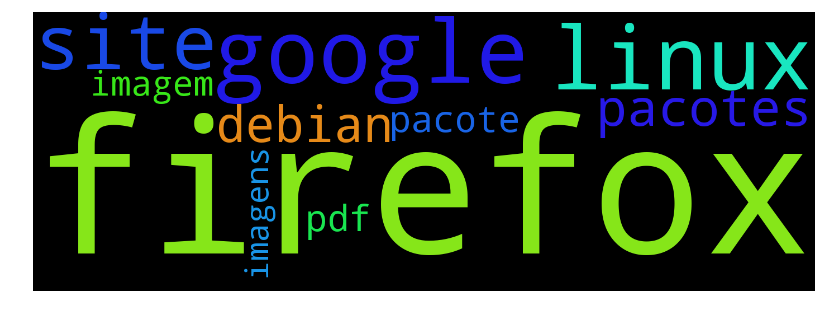

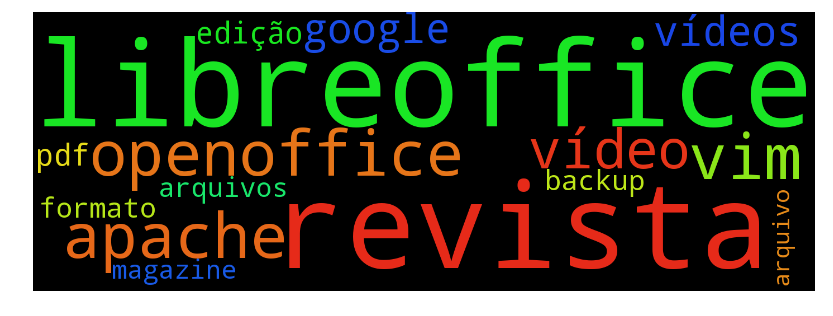

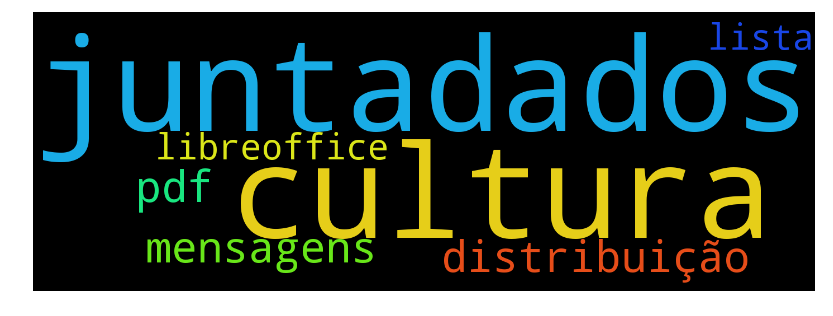

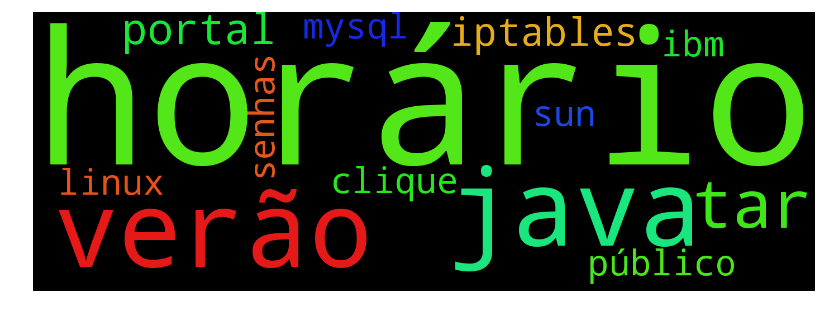

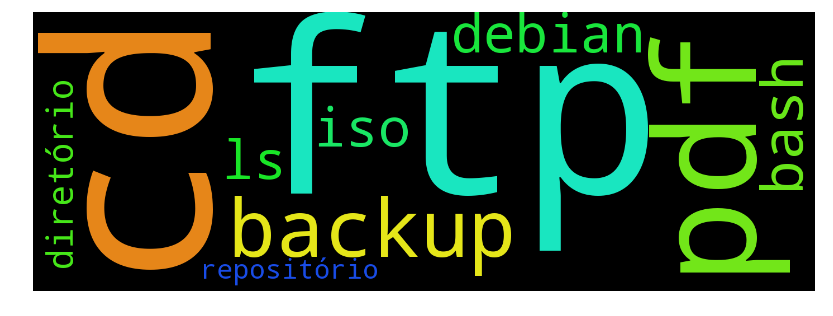

In [59]:
lsi_topics_words_conversion = lambda x: map(lambda y: (y[1], y[0]), x)
show_topics_cloud(lsi,2, lsi_topics_words_conversion)
show_topics_cloud(lsi,5, lsi_topics_words_conversion)
show_topics_cloud(lsi,19, lsi_topics_words_conversion)
show_topics_cloud(lsi,24, lsi_topics_words_conversion)
show_topics_cloud(lsi,40, lsi_topics_words_conversion)
show_topics_cloud(lsi,49, lsi_topics_words_conversion)

## Latent Dirichlet Allocation

In [38]:
%%time
lda = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=30, passes=10, iterations=500)
lda.save('dicas-l_lda.model')
corpus_lda = lda[corpus_bow]
lda.show_topics(30, num_words=20)

CPU times: user 2min 51s, sys: 427 ms, total: 2min 51s
Wall time: 2min 52s


In [39]:
lda_topics_words_conversion = lambda x: map(lambda y: (y[1], y[0]), x)
lda_top_words = topics_top_words(lda,7,lda_topics_words_conversion)
pprint(lda_top_words)

[[u'we', u'world', u"n't", u'my', u'life', u'ted', u'people'],
 [u'xs', u'java', u'name', u'xml', u'type', u'elemento', u'string'],
 [u'mensagens',
  u'mensagem',
  u'lista',
  u'email',
  u'voc\xea',
  u'e-mail',
  u'servi\xe7o'],
 [u'root', u'kernel'],
 [u'internet', u'li', u'thunderbird', u'voc\xea', u'sinal', u'bc', u'tv'],
 [u'lista',
  u'palavras',
  u'ingl\xeas',
  u'l\xedngua',
  u'font',
  u'inglesa',
  u'txt'],
 [u'file', u'version', u'use', u'system', u'files', u'time', u'help'],
 [u'senha', u'direito', u'senhas', u'direitos', u'ser', u'voc\xea', u'lei'],
 [u'google', u'formato', u'texto', u'pdf', u'documento', u'voc\xea', u'html'],
 [u'script', u'nao', u'nagios', u'arquivo', u'bash', u'voce', u'usuario'],
 [u'debian',
  u'pacote',
  u'apt-get',
  u'ubuntu',
  u'install',
  u'pacotes',
  u'instalar'],
 [u'voc\xea',
  u'ser',
  u'sistema',
  u'dados',
  u'informa\xe7\xf5es',
  u'projeto',
  u'al\xe9m'],
 [u'voc\xea',
  u'arquivo',
  u'usu\xe1rio',
  u'ssh',
  u'sudo',
  u'cli

In [60]:
#Number of topics x Number of documents
#show_topics_distrib(corpus_lda,36)
#Topics popularity
#show_topics_popularity(corpus_lda, 30)

In [41]:
print_first_docs_and_their_main_topics(corpus_lda, lda)

DOCUMENT 0
[u'caso', u'zipline', u'colabora\xe7\xe3o', u'cezar', u'taurion', u'exemplo', u'interessante', u'empresa', u'software', u'brasileira', u'localizada', u'interior', u'rio', u'sul', u'zipline', u'tecnologia', u'nove', u'anos', u'exist\xeancia', u'trabalha', u'principalmente', u'hospedagem', u'sites', u'administra\xe7\xe3o', u'servidores', u'empresas', u'regi\xe3o', u'percebeu', u'mercado', u'hospedagem', u'sites', u'canibalizando', u'resolveu', u'entrar', u'novo', u'setor', u'maior', u'valor', u'agregado', u'ent\xe3o', u'surgiu', u'projeto', u'egestor', u'http', u'www.egestor.com.br', u'erp', u'online', u'baseado', u'modelo', u'saas', u'arquitetura', u'multi-inquilino', u'segundo', u'executivos', u'egestor', u'experi\xeancia', u'dando', u'certo', u'mercado', u'relativamente', u'desconhecido', u'maioria', u'vendas', u'servi\xe7o', u'pessoas', u'maior', u'conhecimento', u'tecnologia', u'empres\xe1rios', u'mais', u'tradicionais', u't\xeam', u'certo', u'receio', u'manter', u'inform

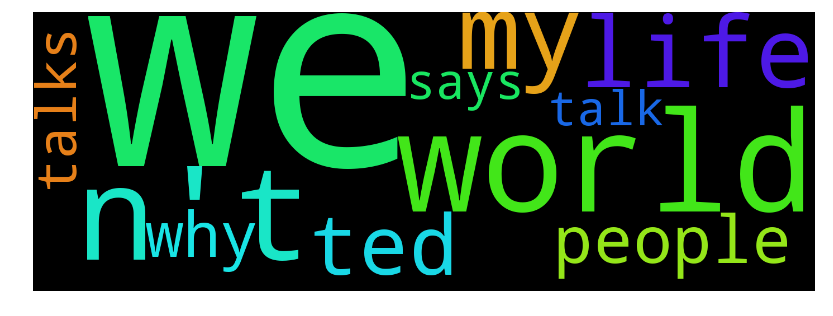

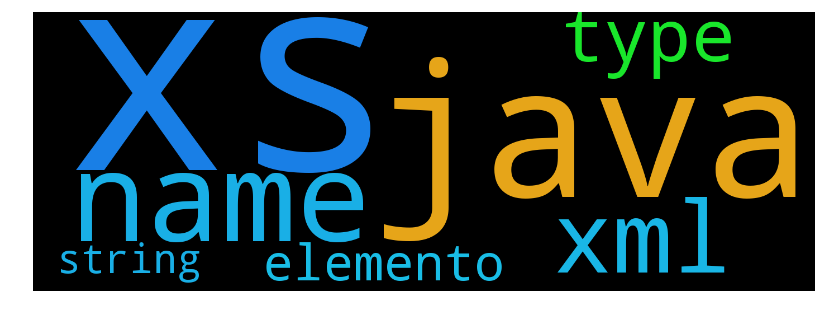

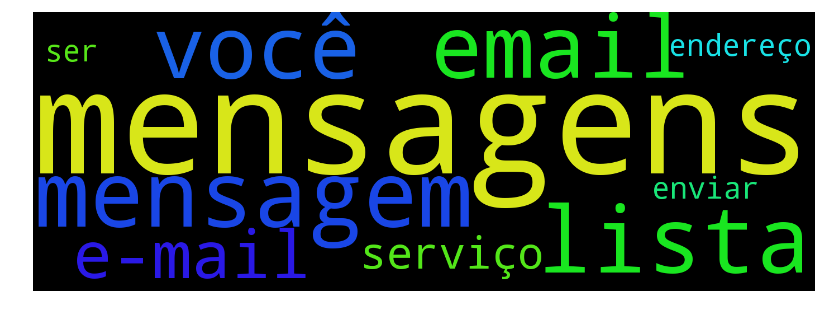

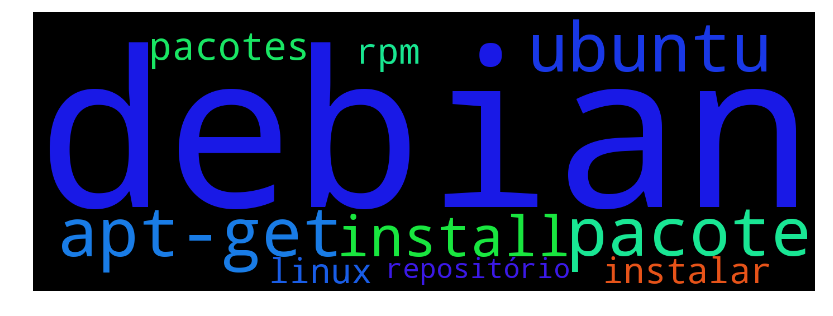

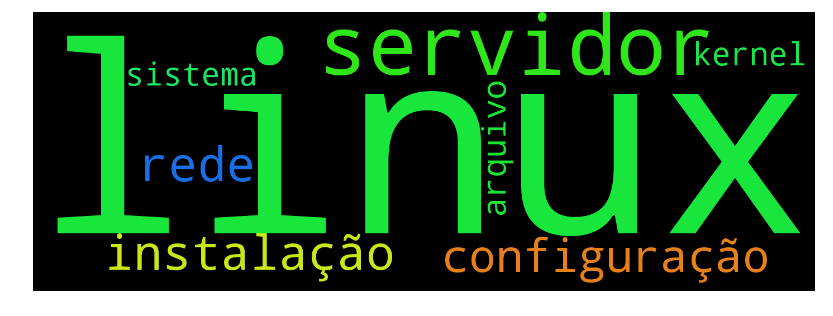

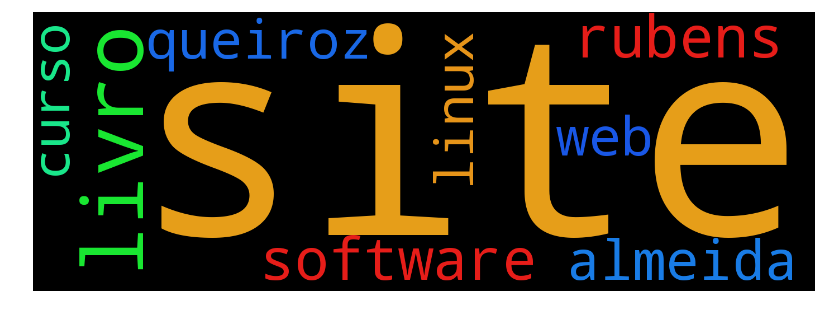

In [61]:
lda_topics_words_conversion = lambda x: map(lambda y: (y[1], y[0]), x)
show_topics_cloud(lda,0, lda_topics_words_conversion)
show_topics_cloud(lda,1, lda_topics_words_conversion)
show_topics_cloud(lda,2, lda_topics_words_conversion)
show_topics_cloud(lda,10, lda_topics_words_conversion)
show_topics_cloud(lda,15, lda_topics_words_conversion)
show_topics_cloud(lda,19, lda_topics_words_conversion)

## Tests

In [43]:
def get_doc_tdidf(doc_id):
    return map(lambda x: (dictionary.id2token[x[0]], x[1]), list(corpus_tfidf)[doc_id])
    

def show_document_profiles(doc_id):
    print corpus[doc_id]
    print "\nTD-IDF"
    show_word_cloud(get_doc_tdidf(doc_id))
    
    #LSI
    corpus_lsi_list = list(corpus_lsi)
    if len(corpus_lsi_list[doc_id]):
        top_topic = sorted(corpus_lsi_list[doc_id], key=lambda t: -t[1])[0]
        print "Top LSI topic:",top_topic
        show_topics_cloud(lsi, top_topic[0], lsi_topics_words_conversion)
        
    #LDA
    corpus_lda_list = list(corpus_lda)
    if len(corpus_lda_list[doc_id]):
        top_topic = sorted(corpus_lda_list[doc_id], key=lambda t: -t[1])[0]
        print "Top LDA topic:",top_topic
        show_topics_cloud(lda, top_topic[0], lda_topics_words_conversion) 

### Utility functions for working with term rankings.
from https://github.com/derekgreene/dynamic-nmf/blob/master/unsupervised/rankings.py

In [44]:
def term_rankings_size( term_rankings ):
        """
        Return the number of terms covered by a list of multiple term rankings.
        """
        m = 0 
        for ranking in term_rankings:
                if m == 0:
                        m = len(ranking)
                else:
                        m = min( len(ranking), m ) 
        return m

def truncate_term_rankings( orig_rankings, top ):
        """
        Truncate a list of multiple term rankings to the specified length.
        """
        if top < 1:
                return orig_rankings
        trunc_rankings = []
        for ranking in orig_rankings:
                trunc_rankings.append( ranking[0:min(len(ranking),top)] )
        return trunc_rankings

def format_term_rankings( term_rankings, term_weights, labels = None, top = 10 ):
        """
        Format a list of multiple term rankings using PrettyTable.
        """
        from prettytable import PrettyTable
        # add header
        header = ["Rank"]
        if labels is None:
                for i in range( len(term_rankings) ):
                        header.append("C%02d" % (i+1) )
        else:
                for label in labels:
                        header.append(label)
        tab = PrettyTable(header)
        tab.align["Rank"] = "r"
        for label in header[1:]:
                tab.align[label] = "l"
        # add body
        for pos in range(top):
                row = [ str(pos+1) ]
                for ranking, weight in zip(term_rankings, term_weights):
                        # have we run out of terms?
                        if len(ranking) <= pos:
                                row.append( "" )
                        else:
                                row.append( ranking[pos] + ' (' + str("{0:.4f}".format(weight[pos])) + ')' )
                tab.add_row( row )
        return tab

### Within-topic Coherence and Terms Similary
https://github.com/derekgreene/dynamic-nmf/blob/master/unsupervised/coherence.py

In [45]:
class ModelSimilarity:
        ''' 
        Uses a model (e.g. Word2Vec model) to calculate the similarity between two terms.
        '''
        def __init__( self, model ):
            self.model = model    

        def similarity( self, ranking_i, ranking_j ):
            sim = 0.0 
            pairs = 0 
            for term_i in ranking_i:
                    for term_j in ranking_j:
                            try:    
                                    #Dealing with words ngrams on topics
                                    sims_ngrams = []
                                    for term_i_word in term_i.split(' '):
                                            for term_j_word in term_j.split(' '):
                                                    sims_ngrams.append(self.model.similarity(term_i_word, term_j_word))
                                    sim += float(sum(sims_ngrams)) / len(sims_ngrams)
                                    pairs += 1
                            except Exception as e:
                                    print "Failed pair (%s,%s)" % (term_i,term_j)
                                    print "Unexpected error:", sys.exc_info()

                                    pass
            if pairs == 0:
                    return 0.0 
            return sim/pairs

class WithinTopicMeasure:
        '''
        Measures within-topic coherence for a topic model, based on a set of term rankings.
        '''
        def __init__( self, metric ):
            self.metric = metric

        def evaluate_ranking( self, term_ranking ):
            return self.metric.similarity( term_ranking, term_ranking )

        def evaluate_rankings( self, term_rankings ):
            scores = []
            overall = 0.0 
            for topic_index in range(len(term_rankings)):
                    score = self.evaluate_ranking( term_rankings[topic_index] ) 
                    scores.append( score )
                    overall += score
            overall /= len(term_rankings)
            return overall

In [47]:
%%time
# Build the Word2Vec model from the documents
corpus_filled = filter(lambda x: len(x) > 0, corpus_tokens)
word2vec_model = models.Word2Vec(corpus_filled, size=100, window=5, min_count=5)
# Save the Word2Vec model
word2vec_model.save("dicas-l_w2v_model.bin")

CPU times: user 12.4 s, sys: 208 ms, total: 12.6 s
Wall time: 12.3 s


In [48]:
pprint(word2vec_model.most_similar(positive=['linux'], negative=['livro'], topn=20))

[(u'phoenix', 0.4513813555240631),
 (u'serial', 0.4494943618774414),
 (u'scsi0', 0.4458822011947632),
 (u'raid', 0.4432910084724426),
 (u'nofile', 0.4431178867816925),
 (u'scsi', 0.43602484464645386),
 (u'inventory', 0.42557403445243835),
 (u'firmware', 0.4212775230407715),
 (u'windows', 0.42106759548187256),
 (u'menuentry', 0.41855040192604065),
 (u'r2', 0.41718950867652893),
 (u'direct-access', 0.4150129556655884),
 (u'lun', 0.41302505135536194),
 (u'filesystem', 0.41223230957984924),
 (u'ulimit', 0.41147223114967346),
 (u'client', 0.4092823565006256),
 (u'fat', 0.4088023602962494),
 (u'bsd', 0.4078122675418854),
 (u'ro', 0.4055655598640442),
 (u'fuse', 0.40432244539260864)]


In [49]:
print word2vec_model.doesnt_match(u'distribuição linux inglês'.split())

inglês


In [50]:
print word2vec_model.similarity('linux', 'windows')
print word2vec_model.similarity('linux', 'livre')
print word2vec_model.similarity('windows', 'livre')

0.434565701916
0.268981693186
0.153559479961


In [51]:
validation_measure = WithinTopicMeasure(ModelSimilarity(word2vec_model))
coherence_score = validation_measure.evaluate_rankings(lsi_top_words)
print coherence_score

0.274545876775


In [52]:
validation_measure = WithinTopicMeasure(ModelSimilarity(word2vec_model))
coherence_score = validation_measure.evaluate_rankings(lda_top_words)
print coherence_score

0.454889229243


In [55]:
lsi_coherence_scores = {}
lda_coherence_scores = {}
for k in range(1,101):
    lsi_k = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=k)
    lsi_top_words_k = topics_top_words(lsi_k,10,lsi_topics_words_conversion)
    lsi_coherence_score = validation_measure.evaluate_rankings(lsi_top_words_k)
    lsi_coherence_scores[k] = lsi_coherence_score
    print "LSI - k: {}, score: {}".format(k, lsi_coherence_score)
    lda_k = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=k, passes=10)
    lda_top_words_k = topics_top_words(lda_k,10,lda_topics_words_conversion)
    lda_coherence_score = validation_measure.evaluate_rankings(lda_top_words_k)
    lda_coherence_scores[k] = lda_coherence_score
    print "LDA - k: {}, score: {}".format(k, lda_coherence_score)

LSI - k: 1, score: 0.205988495542
LDA - k: 1, score: 0.242534154382
LSI - k: 2, score: 0.258870759187
LDA - k: 2, score: 0.255536551761
LSI - k: 3, score: 0.265038458801
LDA - k: 3, score: 0.293936424633
LSI - k: 4, score: 0.359828934014
LDA - k: 4, score: 0.321900100854
LSI - k: 5, score: 0.295609904288
LDA - k: 5, score: 0.341126580936
LSI - k: 6, score: 0.402473735106
LDA - k: 6, score: 0.336024865322
LSI - k: 7, score: 0.292418053996
LDA - k: 7, score: 0.359786413676
LSI - k: 8, score: 0.306948532485
LDA - k: 8, score: 0.375895157813
LSI - k: 9, score: 0.325779328068
LDA - k: 9, score: 0.348036508437
LSI - k: 10, score: 0.354904364518
LDA - k: 10, score: 0.449323225607
LSI - k: 11, score: 0.341961959263
LDA - k: 11, score: 0.377807140117
LSI - k: 12, score: 0.268200639694
LDA - k: 12, score: 0.462799647117
LSI - k: 13, score: 0.368254143838
LDA - k: 13, score: 0.396744116459
LSI - k: 14, score: 0.424816185416
LDA - k: 14, score: 0.435583462461
LSI - k: 15, score: 0.286467107218
LDA

!["Topic coherence calculated using word2vec (TC-W2V) for the LSI and LDA models. The number of topics (k) is varying form 1 to 100"](img/tc-w2v.png "Topic coherence calculated using word2vec (TC-W2V) for the LSI and LDA models. The number of topics (k) is varying form 1 to 100")

## References
1. David M. Blei, Andrew Y. Ng, and Michael I. Jordan. Latent dirichlet allocation. J. Mach. Learn. Res., 3:993–1022, March 2003. 1
1. Matthew D. Hoffman, David M. Blei, and Francis Bach. Online learning for latent dirichlet allocation. In In NIPS, 2010.
1. Thomas K. Landauer, Peter W. Foltz, and Darrell Laham. An Introduction to Latent Semantic Analysis. Discourse Processes, (25):259–284, 1998. 
1. Scott Deerwester, Susan T. Dumais, George W. Furnas, Thomas K. Landauer, and Richard Harshman. Indexing by latent semantic analysis. JOURNAL OF THE AMERICAN SOCIETY FOR INFORMATION SCIENCE, 41(6):391–407, 1990